# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from datetime import timedelta

In [2]:
today = datetime.datetime.now() - datetime.timedelta(days = 1) #minus 1 day to mitigate inconsistency
tomorrow = today + datetime.timedelta(days =2)

today

datetime.datetime(2024, 11, 19, 22, 28, 59, 512111)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159320
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv_improved',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_improved",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='8.615246E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
aq_fg = fs.get_feature_group(
    name='air_quality_improved',
    version=1,
)
#aq_batch_data = aq_fg.filter(aq_fg.date > today).read()
aq_batch_data = aq_fg.read()
aq_batch_data

#for col in aq_batch_data.columns:
#    print(f"{col}: {aq_batch_data[col].dtype}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.88s) 
date: datetime64[us, UTC]
pm25: float32
country: object
city: object
street: object
url: object
pm25_rolling_mean_3d: float64
pm25_rolling_std_3d: float64
pm25_rolling_max_3d: float64
pm25_rolling_mean_7d: float64
pm25_rolling_std_7d: float64
pm25_rolling_max_7d: float64
pm25_lag_1d: float32
pm25_lag_2d: float32
pm25_lag_3d: float32
pm25_diff_1d: float32
pm25_pct_change: float32
month: int32
day_of_week: int32
is_weekend: int32
month_sin: float64
month_cos: float64
pm25_ema_3d: float64
pm25_ema_7d: float64
pm25_trend_3d: float64
pm25_volatility_3d: float64
pm25_trend_7d: float64
pm25_volatility_7d: float64
pm25_trend_14d: float64
pm25_volatility_14d: float64
pm25_zscore: float32
pm25_percentile: float64
pm25_skew_7d: float64


In [22]:
def calculate_pm25_features_and_forecast(df, pm25_column='pm25', date_column='date', forecast_days=7):
    """
    Calculate PM2.5 features and forecast next n days of values.
    """
    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()
    
    # Create forecast DataFrame with dates
    last_date = result[date_column].max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    forecast_df = pd.DataFrame({date_column: forecast_dates})
    
    def forecast_features(data, forecast_days):
        forecasts = {date_column: forecast_dates}
        
        def linear_forecast(values, periods):
            X = np.arange(len(values)).reshape(-1, 1)
            y = values
            model = LinearRegression()
            model.fit(X, y)
            future_X = np.arange(len(values), len(values) + periods).reshape(-1, 1)
            return model.predict(future_X)
        
        # Last 30 days of data for forecasting
        recent_data = data.tail(30)
        
        # Base PM2.5 forecast
        base_forecast = linear_forecast(recent_data[pm25_column].values, forecast_days)
        forecasts[pm25_column] = base_forecast
        
        # Rolling means (3d, 7d)
        forecasts['pm25_rolling_mean_3d'] = np.pad(np.convolve(base_forecast, np.ones(3)/3, mode='valid'),
                                                  (0, forecast_days - forecast_days + 2), 'edge')[:forecast_days]
        forecasts['pm25_rolling_mean_7d'] = np.pad(np.convolve(base_forecast, np.ones(7)/7, mode='valid'),
                                                  (0, forecast_days - forecast_days + 6), 'edge')[:forecast_days]
        
        # Rolling standard deviations (3d, 7d)
        for window in ['3d', '7d']:
            col = f'pm25_rolling_std_{window}'
            last_std = data[col].tail(7).mean()
            forecasts[col] = np.full(forecast_days, last_std)
            
            # Rolling max
            col = f'pm25_rolling_max_{window}'
            last_max = data[col].tail(7).mean()
            forecasts[col] = np.full(forecast_days, last_max)
        
        # Lag features
        for lag in [1, 2, 3]:
            col = f'pm25_lag_{lag}d'
            forecasts[col] = np.roll(base_forecast, lag)
            forecasts[col][:lag] = base_forecast[0]
        
        # Diff and percent change
        forecasts['pm25_diff_1d'] = np.diff(np.concatenate([[base_forecast[0]], base_forecast]))
        forecasts['pm25_pct_change'] = np.diff(np.concatenate([[base_forecast[0]], base_forecast])) / base_forecast[0]
        
        # Time-based features
        forecast_dates_features = pd.DataFrame({'date': forecast_dates})
        forecasts['month'] = forecast_dates.month
        forecasts['day_of_week'] = forecast_dates.dayofweek
        forecasts['is_weekend'] = (forecast_dates.dayofweek >= 5).astype(int)
        forecasts['month_sin'] = np.sin(2 * np.pi * forecast_dates.month / 12)
        forecasts['month_cos'] = np.cos(2 * np.pi * forecast_dates.month / 12)
        
        # EMA features
        alpha_3d = 2/(3+1)
        alpha_7d = 2/(7+1)
        last_ema_3d = data['pm25_ema_3d'].iloc[-1]
        last_ema_7d = data['pm25_ema_7d'].iloc[-1]
        
        ema_3d = np.zeros(forecast_days)
        ema_7d = np.zeros(forecast_days)
        
        for i in range(forecast_days):
            if i == 0:
                ema_3d[i] = alpha_3d * base_forecast[i] + (1-alpha_3d) * last_ema_3d
                ema_7d[i] = alpha_7d * base_forecast[i] + (1-alpha_7d) * last_ema_7d
            else:
                ema_3d[i] = alpha_3d * base_forecast[i] + (1-alpha_3d) * ema_3d[i-1]
                ema_7d[i] = alpha_7d * base_forecast[i] + (1-alpha_7d) * ema_7d[i-1]
        
        forecasts['pm25_ema_3d'] = ema_3d
        forecasts['pm25_ema_7d'] = ema_7d
        
        # Trends and volatilities
        for period in ['3d', '7d', '14d']:
            # Trend
            col = f'pm25_trend_{period}'
            last_trend = data[col].tail(7).mean()
            forecasts[col] = np.full(forecast_days, last_trend)
            
            # Volatility
            col = f'pm25_volatility_{period}'
            last_vol = data[col].tail(7).mean()
            forecasts[col] = np.full(forecast_days, last_vol)
        
        # Statistical measures
        mean_hist = data[pm25_column].mean()
        std_hist = data[pm25_column].std()
        forecasts['pm25_zscore'] = (base_forecast - mean_hist) / std_hist
        
        hist_vals = data[pm25_column].values
        forecasts['pm25_percentile'] = np.array([stats.percentileofscore(hist_vals, x) for x in base_forecast])
        
        last_skew = data['pm25_skew_7d'].tail(7).mean()
        forecasts['pm25_skew_7d'] = np.full(forecast_days, last_skew)
        
        # Static columns
        static_cols = ['country', 'city', 'street', 'url']
        for col in static_cols:
            if col in data.columns:
                forecasts[col] = [data[col].iloc[-1]] * forecast_days
        
        return pd.DataFrame(forecasts)
    
    # Generate forecasts
    forecast_values = forecast_features(result, forecast_days)
    
    return result, forecast_values

In [23]:
   
    # Calculate features and forecast
    historical_df, forecast_df = calculate_pm25_features_and_forecast(aq_batch_data, 
                                                                    pm25_column='pm25',
                                                                    date_column='date',
                                                                    forecast_days=8)


In [24]:
forecast_df = forecast_df.drop(columns=["pm25"])
forecast_df

,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d,country,city,street,url
0,2024-11-21 00:00:00+00:00,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,0.158534,2.464286,0.175581,0.100051,54.129353,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
1,2024-11-22 00:00:00+00:00,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,0.158534,2.464286,0.175581,0.086710,54.129353,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
2,2024-11-23 00:00:00+00:00,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,0.158534,2.464286,0.175581,0.073369,53.134328,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
3,2024-11-24 00:00:00+00:00,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,0.158534,2.464286,0.175581,0.060028,53.134328,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
4,2024-11-25 00:00:00+00:00,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,0.158534,2.464286,0.175581,0.046686,53.134328,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
5,2024-11-26 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,0.158534,2.464286,0.175581,0.033345,53.134328,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
6,2024-11-27 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,0.158534,2.464286,0.175581,0.020004,51.343284,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651
7,2024-11-28 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,0.158534,2.464286,0.175581,0.006663,51.343284,-0.150991,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651


In [25]:
weather_fg = fs.get_feature_group(
    name='weather_improved',
    version=1,
)
wt_batch_data = weather_fg.filter(weather_fg.date >= today).read()
#wt_batch_data = weather_fg.read()
wt_batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency
0,2024-11-26 00:00:00+00:00,26.000000,0.7,3.877318,158.198532,semarang,25.983334,0.900000,6.297955,100.810280,18.199999,0.371392,-0.928476,70.567192,0,0.143604
1,2024-11-27 00:00:00+00:00,26.049999,0.3,7.386582,136.974930,semarang,26.250000,0.433333,5.877650,192.420456,7.815000,0.682318,-0.731055,57.726139,0,0.273071
2,2024-11-23 00:00:00+00:00,24.750000,0.9,8.049845,153.435013,semarang,25.150000,1.166667,9.115790,199.233658,22.275000,0.447213,-0.894428,179.310287,0,0.312615
3,2024-11-22 00:00:00+00:00,25.850000,0.1,7.993298,97.765083,semarang,25.616667,1.733333,10.138936,206.626740,2.585000,0.990830,-0.135112,20.662674,0,0.297702
4,2024-11-24 00:00:00+00:00,25.250000,1.7,8.647496,177.614105,semarang,25.283333,0.900000,8.230213,218.349274,42.925003,0.041630,-0.999133,371.193787,0,0.329428
5,2024-11-20 00:00:00+00:00,26.150000,2.6,11.119281,150.945496,semarang,25.616667,1.733333,10.138936,290.769196,67.989998,0.485641,-0.874158,755.999878,0,0.409550
6,2024-11-28 00:00:00+00:00,26.799999,0.1,3.893995,146.309906,semarang,26.283333,0.366667,5.052632,104.359070,2.680000,0.554701,-0.832050,10.435907,1,0.140072
7,2024-11-29 00:00:00+00:00,25.400000,0.9,2.545584,98.130020,semarang,26.083333,0.433333,4.608720,64.657837,22.859999,0.989950,-0.141420,58.192051,0,0.096424
8,2024-11-25 00:00:00+00:00,26.700001,0.3,6.369050,137.290634,semarang,25.566667,0.966667,7.688797,170.053635,8.010000,0.678280,-0.734804,51.016094,1,0.229930
9,2024-11-21 00:00:00+00:00,24.850000,2.5,11.304229,127.234917,semarang,25.616667,1.733333,10.138936,280.910095,62.125000,0.796161,-0.605084,702.275269,0,0.437301


In [35]:
# First, standardize the dates in both dataframes
def standardize_dates(df):
    """
    Standardize dates by converting to datetime and removing timezone information
    """
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    return df

# Standardize both dataframes
forecast_features = standardize_dates(forecast_df)
wt_batch_data = standardize_dates(wt_batch_data)

# Merge based on date
batch_data = pd.merge(
    forecast_features,
    wt_batch_data,
    on='date',
    how='outer',
    suffixes=('_forecast', '_weather')
)

# Sort by date
batch_data = batch_data.sort_values('date')

# Drop rows with any NaN values
batch_data = batch_data.dropna()

# Reset index after dropping rows
batch_data = batch_data.reset_index(drop=True)

#batch_data = batch_data.dropna(subset=['month'])

batch_data

,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency
0,2024-11-21,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,25.616667,1.733333,10.138936,280.910095,62.125000,0.796161,-0.605084,702.275269,0,0.437301
1,2024-11-22,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,25.616667,1.733333,10.138936,206.626740,2.585000,0.990830,-0.135112,20.662674,0,0.297702
2,2024-11-23,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,25.150000,1.166667,9.115790,199.233658,22.275000,0.447213,-0.894428,179.310287,0,0.312615
3,2024-11-24,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,25.283333,0.900000,8.230213,218.349274,42.925003,0.041630,-0.999133,371.193787,0,0.329428
4,2024-11-25,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,25.566667,0.966667,7.688797,170.053635,8.010000,0.678280,-0.734804,51.016094,1,0.229930
5,2024-11-26,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,25.983334,0.900000,6.297955,100.810280,18.199999,0.371392,-0.928476,70.567192,0,0.143604
6,2024-11-27,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,26.250000,0.433333,5.877650,192.420456,7.815000,0.682318,-0.731055,57.726139,0,0.273071
7,2024-11-28,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,26.283333,0.366667,5.052632,104.359070,2.680000,0.554701,-0.832050,10.435907,1,0.140072


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [36]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[[
    'pm25_rolling_mean_3d', 'pm25_rolling_std_3d', 'pm25_rolling_max_3d',
    'pm25_rolling_mean_7d', 'pm25_rolling_std_7d', 'pm25_rolling_max_7d',
    'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d',
    'pm25_diff_1d', 'pm25_pct_change',
    'pm25_ema_3d', 'pm25_ema_7d',
    'pm25_percentile',
    'pm25_skew_7d',
    'pm25_trend_3d', 'pm25_trend_7d', 'pm25_trend_14d',
    'pm25_volatility_3d','pm25_volatility_7d', 'pm25_volatility_14d',
    'pm25_zscore',
    'day_of_week', 'is_weekend', 'month', 'month_cos', 'month_sin',
        'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'temperature_2m_mean_rolling_mean_3d', 'precipitation_sum_rolling_mean_3d', 'wind_speed_10m_max_rolling_mean_3d',
        'temp_wind_interaction', 'temp_precip_interaction', 'temp_wind_precip',
        'wind_direction_sin', 'wind_direction_cos', 'wind_efficiency',
        'high_temp_low_wind' ]])
batch_data

,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25
0,2024-11-21,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,1.733333,10.138936,280.910095,62.125000,0.796161,-0.605084,702.275269,0,0.437301,114.175529
1,2024-11-22,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,1.733333,10.138936,206.626740,2.585000,0.990830,-0.135112,20.662674,0,0.297702,114.793739
2,2024-11-23,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,1.166667,9.115790,199.233658,22.275000,0.447213,-0.894428,179.310287,0,0.312615,115.253098
3,2024-11-24,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,0.900000,8.230213,218.349274,42.925003,0.041630,-0.999133,371.193787,0,0.329428,115.258591
4,2024-11-25,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,0.966667,7.688797,170.053635,8.010000,0.678280,-0.734804,51.016094,1,0.229930,115.402054
5,2024-11-26,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,0.900000,6.297955,100.810280,18.199999,0.371392,-0.928476,70.567192,0,0.143604,115.489899
6,2024-11-27,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,0.433333,5.877650,192.420456,7.815000,0.682318,-0.731055,57.726139,0,0.273071,115.243080
7,2024-11-28,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,0.366667,5.052632,104.359070,2.680000,0.554701,-0.832050,10.435907,1,0.140072,115.175995


In [37]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 48 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 8 non-null      datetime64[ns]
 1   pm25_rolling_mean_3d                 8 non-null      float64       
 2   pm25_rolling_mean_7d                 8 non-null      float64       
 3   pm25_rolling_std_3d                  8 non-null      float64       
 4   pm25_rolling_max_3d                  8 non-null      float64       
 5   pm25_rolling_std_7d                  8 non-null      float64       
 6   pm25_rolling_max_7d                  8 non-null      float64       
 7   pm25_lag_1d                          8 non-null      float64       
 8   pm25_lag_2d                          8 non-null      float64       
 9   pm25_lag_3d                          8 non-null      float64       
 10  pm25_diff_1d      

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [38]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25,city,days_before_forecast_day
0,2024-11-21,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,280.910095,62.125000,0.796161,-0.605084,702.275269,0,0.437301,114.175529,semarang,1
1,2024-11-22,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,206.626740,2.585000,0.990830,-0.135112,20.662674,0,0.297702,114.793739,semarang,2
2,2024-11-23,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,199.233658,22.275000,0.447213,-0.894428,179.310287,0,0.312615,115.253098,semarang,3
3,2024-11-24,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,218.349274,42.925003,0.041630,-0.999133,371.193787,0,0.329428,115.258591,semarang,4
4,2024-11-25,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,170.053635,8.010000,0.678280,-0.734804,51.016094,1,0.229930,115.402054,semarang,5
5,2024-11-26,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,100.810280,18.199999,0.371392,-0.928476,70.567192,0,0.143604,115.489899,semarang,6
6,2024-11-27,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,192.420456,7.815000,0.682318,-0.731055,57.726139,0,0.273071,115.243080,semarang,7
7,2024-11-28,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,104.359070,2.680000,0.554701,-0.832050,10.435907,1,0.140072,115.175995,semarang,8


In [39]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 50 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 8 non-null      datetime64[ns]
 1   pm25_rolling_mean_3d                 8 non-null      float64       
 2   pm25_rolling_mean_7d                 8 non-null      float64       
 3   pm25_rolling_std_3d                  8 non-null      float64       
 4   pm25_rolling_max_3d                  8 non-null      float64       
 5   pm25_rolling_std_7d                  8 non-null      float64       
 6   pm25_rolling_max_7d                  8 non-null      float64       
 7   pm25_lag_1d                          8 non-null      float64       
 8   pm25_lag_2d                          8 non-null      float64       
 9   pm25_lag_3d                          8 non-null      float64       
 10  pm25_diff_1d      

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

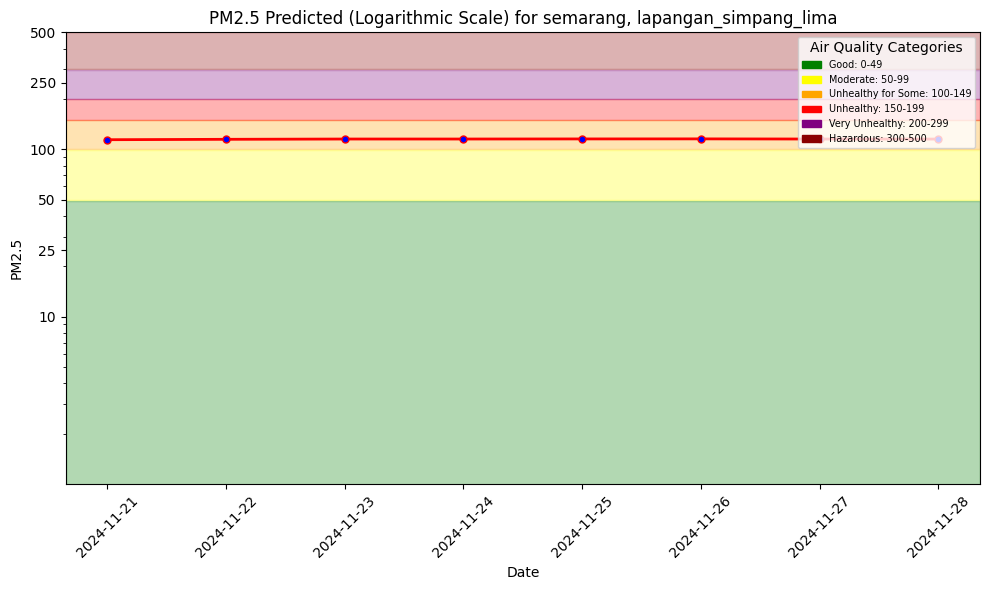

In [40]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [41]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_improved',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [42]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_improved_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159320/jobs/named/aq_predictions_improved_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1115f8da9e0>, None)

In [43]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
#monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
#monitoring_df

monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25,city,days_before_forecast_day
0,2024-11-26 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,100.810280,18.199999,0.371392,-0.928476,70.567192,0,0.143604,115.489899,semarang,6
1,2024-11-27 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,192.420456,7.815000,0.682318,-0.731055,57.726139,0,0.273071,115.243080,semarang,7
2,2024-11-22 00:00:00+00:00,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,206.626740,2.585000,0.990830,-0.135112,20.662674,0,0.297702,114.793739,semarang,2
3,2024-11-21 00:00:00+00:00,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,280.910095,62.125000,0.796161,-0.605084,702.275269,0,0.437301,114.175529,semarang,1
4,2024-11-25 00:00:00+00:00,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,170.053635,8.010000,0.678280,-0.734804,51.016094,1,0.229930,115.402054,semarang,5
5,2024-11-23 00:00:00+00:00,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,199.233658,22.275000,0.447213,-0.894428,179.310287,0,0.312615,115.253098,semarang,3
6,2024-11-28 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,104.359070,2.680000,0.554701,-0.832050,10.435907,1,0.140072,115.175995,semarang,8
7,2024-11-24 00:00:00+00:00,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,218.349274,42.925003,0.041630,-0.999133,371.193787,0,0.329428,115.258591,semarang,4


In [44]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_improved',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


,date,pm25,country,city,street,url,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,...,pm25_ema_7d,pm25_trend_3d,pm25_volatility_3d,pm25_trend_7d,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d
0,2023-05-31 00:00:00+00:00,105.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,108.666667,8.144528,118.0,111.571429,...,110.501333,-1.333333,0.074950,-5.928571,0.084374,16.678571,0.092975,0.720566,0.743028,-0.308756
1,2022-05-27 00:00:00+00:00,69.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,67.000000,7.211103,73.0,66.428571,...,67.243382,-2.333333,0.107628,-3.928571,0.153237,1.285714,0.209159,-0.943490,0.188247,-0.541525
2,2024-09-23 00:00:00+00:00,84.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,95.000000,11.000000,106.0,87.428571,...,90.384138,4.166667,0.115789,-1.642857,0.159975,-0.214286,0.139076,-0.250133,0.442231,-0.294547
3,2024-05-15 00:00:00+00:00,106.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,113.333333,10.214369,125.0,100.428571,...,106.031802,12.833333,0.090127,-8.357143,0.149123,14.571429,0.140902,0.766790,0.755976,0.218035
4,2022-04-14 00:00:00+00:00,98.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,104.666667,14.224392,121.0,92.000000,...,96.146481,10.166667,0.135902,2.785714,0.168858,-0.428571,0.146093,0.397000,0.662849,0.738984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2023-07-15 00:00:00+00:00,109.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,109.000000,11.000000,120.0,105.000000,...,104.872744,4.000000,0.100917,5.000000,0.139538,2.321429,0.138175,0.905461,0.793825,-1.130198
1001,2024-08-11 00:00:00+00:00,97.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,98.666667,1.527525,100.0,105.285714,...,101.264014,-7.666667,0.015482,6.142857,0.089219,-7.428571,0.186273,0.350776,0.646912,0.777546
1002,2024-05-11 00:00:00+00:00,86.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,88.666667,10.263203,100.0,106.000000,...,98.878288,-14.666667,0.115750,2.571429,0.169899,15.928571,0.165072,-0.157686,0.470618,-0.353569
1003,2023-04-13 00:00:00+00:00,61.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,72.000000,10.148892,81.0,80.142857,...,78.644753,-7.000000,0.140957,-5.571429,0.140511,-6.642857,0.226337,-1.313280,0.086155,-0.415397


In [46]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])



### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

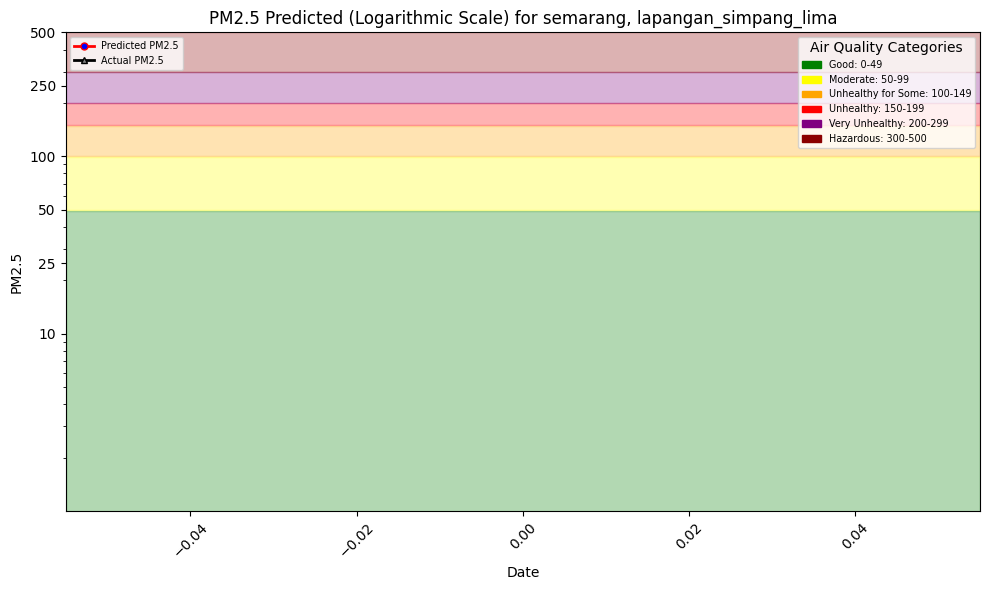

In [47]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---